In [1]:
from torch import nn
import torch
from torch.nn.functional import cross_entropy,softmax
from utils import Dataset,process_w2v_data
from visual import show_w2v_word_embedding

In [2]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [12]:
class SkipGram(nn.Module):

    def __init__(self,v_dim,emb_dim):
        super().__init__()
        self.v_dim = v_dim
        self.embeddings = nn.Embedding(v_dim,emb_dim)
        self.embeddings.weight.data.normal_(0,0.1)
        self.hidden_out = nn.Linear(emb_dim,v_dim)

        self.opt = torch.optim.Adam(self.parameters(),lr=0.01)
    
    def forward(self,x,training=None, mask=None):
        # x.shape = [n,]
        o = self.embeddings(x)  # [n, emb_dim]
        return o
    
    def loss(self,x,y,training=None):
        embedded = self(x,training)
        pred= self.hidden_out(embedded)
        return cross_entropy(pred,y)
    
    def step(self,x,y):
        self.opt.zero_grad()
        loss = self.loss(x,y,True)
        loss.backward()
        self.opt.step()
        return loss.detach().cpu().numpy()

In [13]:
def train(model,data):
    if torch.cuda.is_available():
        print("GPU train avaliable")
        device =torch.device("cuda")
        model = model.cuda()
    else:
        device = torch.device("cpu")
        model = model.cpu()
    for t in range(8000):
        bx,by = data.sample(16)
        
        bx,by = torch.from_numpy(bx).to(device), torch.from_numpy(by).to(device)

        loss = model.step(bx.long(),by.long())
        if t%200 == 0:
            print(f"step: {t}  |  loss: {loss}")

In [14]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#def show_w2v_word_embedding(model, data, path):
def show_w2v_word_embedding(model, data):
    word_emb = model.cpu().embeddings.weight.data.numpy()
    for i in range(data.num_word):
        c = "blue"
        try:
            int(data.i2v[i])
        except:
            c = "red"

        plt.text(word_emb[i, 0], word_emb[i, 1], s=data.i2v[i], color=c, weight="bold")

    plt.xlim(word_emb[:, 0].min() - 0.5, word_emb[:, 0].max() + 0.5)
    plt.ylim(word_emb[:, 1].min() - 0.5, word_emb[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
#     plt.savefig(path, dpi=300, format="png")
    plt.show()

All vocabularies are sorted by frequency in decresing oreder
5 expample pairs:
 [[16 14]
 [16  9]
 [14 16]
 [14  9]
 [14 12]]
GPU train avaliable
step: 0  |  loss: 3.1692371368408203
step: 200  |  loss: 3.1414122581481934
step: 400  |  loss: 2.8629777431488037
step: 600  |  loss: 2.7646987438201904
step: 800  |  loss: 2.584993839263916
step: 1000  |  loss: 2.4769999980926514
step: 1200  |  loss: 2.489748001098633
step: 1400  |  loss: 2.536696195602417
step: 1600  |  loss: 2.5084307193756104
step: 1800  |  loss: 2.6421804428100586
step: 2000  |  loss: 2.180467128753662
step: 2200  |  loss: 2.7988944053649902
step: 2400  |  loss: 2.746054172515869
step: 2600  |  loss: 2.4672622680664062
step: 2800  |  loss: 2.641099452972412
step: 3000  |  loss: 2.5494205951690674
step: 3200  |  loss: 2.7757585048675537
step: 3400  |  loss: 2.1899681091308594
step: 3600  |  loss: 2.3737568855285645
step: 3800  |  loss: 2.2809228897094727
step: 4000  |  loss: 2.676994800567627
step: 4200  |  loss: 2.10329

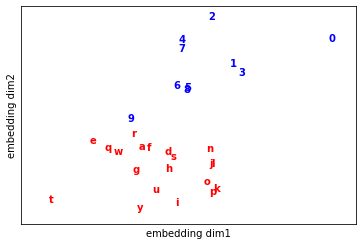

In [15]:
if __name__ == "__main__":
    d = process_w2v_data(corpus,skip_window=2, method="skip_gram")
    m = SkipGram(d.num_word, 2)
    train(m,d)
    #show_w2v_word_embedding(m,d,"./visual/results/cbow.png")
    show_w2v_word_embedding(m,d)